<a href="https://colab.research.google.com/github/marcoslashpro/StockPredictor/blob/main/StockPredictorBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Today we'll excecute a time series analysis on stock data using a XGBoost model.

We already experimented with this and on a 256 training example dataset. The better accuracy score that we were able to obtain was 0.58, will a bigger dataset make it better?

We are currently aiming for 0.70, let's go

# **Imports**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import kagglehub
import sklearn.metrics as skm

# **Data Engineering**

---

You can find the dataset we are working on [here](https://www.kaggle.com/datasets/mattiuzc/stock-exchange-data)

The file path contains three different dataset:

 - indexInfo with the information of describing the features of the dataset, we'll save this as info_data, might come back usefull
 - indexData and indexProcessed, the difference between the two is that the processed one has the closing prices in USD, we'll use indexData instead

In [ ]:
dataset = kagglehub.dataset_download('mattiuzc/stock-exchange-data')

for f in os.listdir(dataset):
  if f == 'indexInfo.csv':
    file_path = os.path.join(dataset, f)
    info_data = pd.read_csv(file_path)
  if f == 'indexData.csv':
    file_path = os.path.join(dataset, f)
    df = pd.read_csv(file_path)

df

100%|██████████| 4.56M/4.56M [00:00<00:00, 52.8MB/s]

Extracting files...


,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0
...,...,...,...,...,...,...,...,...
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,155179900.0


## **Features analysis**

---

Let's start by seeing what are we working with

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      112457 non-null  object 
 1   Date       112457 non-null  object 
 2   Open       110253 non-null  float64
 3   High       110253 non-null  float64
 4   Low        110253 non-null  float64
 5   Close      110253 non-null  float64
 6   Adj Close  110253 non-null  float64
 7   Volume     110253 non-null  float64
dtypes: float64(6), object(2)
memory usage: 6.9+ MB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,110253.000000,110253.000000,110253.000000,110253.000000,110253.000000,1.102530e+05
mean,7658.515222,7704.372961,7608.000422,7657.545872,7657.351729,1.273975e+09
std,9011.478913,9066.638548,8954.506981,9011.510444,9011.608900,4.315783e+09
min,54.869999,54.869999,54.869999,54.869999,54.869999,0.000000e+00
25%,1855.030029,1864.510010,1843.979980,1855.060059,1854.179565,0.000000e+00
50%,5194.089844,5226.279785,5154.049805,5194.750000,5194.750000,4.329000e+05
75%,10134.299810,10207.820310,10060.349610,10134.830080,10134.830080,1.734314e+08
max,68775.062500,69403.750000,68516.992190,68775.062500,68775.062500,9.440374e+10


From the description of the dataframe, everything seems fine, except the 'Volume' columns, let's investigate a bit more on that

In [ ]:
df['Volume'].describe()

,Volume
count,1.102530e+05
mean,1.273975e+09
std,4.315783e+09
min,0.000000e+00
25%,0.000000e+00
50%,4.329000e+05
75%,1.734314e+08
max,9.440374e+10


We can see:

 - Extreme difference between the mean and the std;
 - Extremely high highs;
 - A lot of data points are 0

Let's make a boxplot to better see what is going on

<Axes: xlabel='Date', ylabel='Volume'>

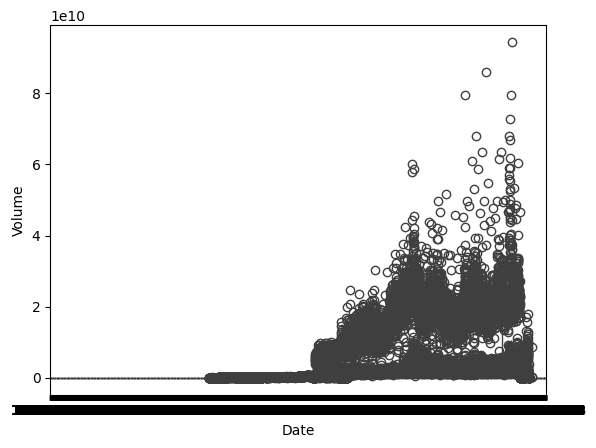

In [ ]:
sns.boxplot(x=df['Date'], y=df['Volume'])

Excuse the shittiness of this boxplot, but I am still working on my plotting skills.

Altough we can see, that the high highs are justified, with some extreme outliers that should not impact the model so much (since we're working with xgboost).

The main issues lies in the 0 datapoints, most of the fall at the beggining of the dataset, making me think that they were not keeping track of the volume feature at the beginning, decided to add it later on and replaced the missing values with 0s.

Two ways to solve this would be:

 - Manually insert the missing features;
 - Removing the part of the dataset in which the values are == 0

Let's try and implement the easiest approach, removing the parts with missing values, let's see how many training examples we have left, and let's work from there

In [ ]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
  """
  Returns a DataFrame with rows removed where the 'Volume' column is equal to 0.

  This function efficiently removes rows from the input DataFrame where the
  'Volume' column has a value of 0. It leverages Pandas' boolean indexing
  for a vectorized and faster operation compared to row-wise iteration.

  Args:
    df (pd.DataFrame): The input DataFrame. It is expected to have a 'Volume' column.

  Returns:
    pd.DataFrame: A new DataFrame with rows where 'Volume' is 0 removed.
  """
  df_cleaned = df[df['Volume'] != 0].copy() # Boolean indexing to filter rows
  return df_cleaned

clean_df = clean_dataframe(df)

In [ ]:
#Let's check the output

clean_df['Volume'].describe()

,Volume
count,6.816000e+04
mean,2.060733e+09
std,5.339244e+09
min,1.000000e+02
25%,1.785225e+06
50%,1.027414e+08
75%,1.559118e+09
max,9.440374e+10


In [ ]:
clean_df

,Index,Date,Open,High,Low,Close,Adj Close,Volume
289,NYA,1967-02-23,NaN,NaN,NaN,NaN,NaN,NaN
8815,NYA,2001-01-03,6968.830078,6968.830078,6968.830078,6968.830078,6968.830078,1.880700e+09
8816,NYA,2001-01-04,6894.810059,6894.810059,6894.810059,6894.810059,6894.810059,2.169400e+09
8817,NYA,2001-01-05,6774.060059,6774.060059,6774.060059,6774.060059,6774.060059,1.430800e+09
8818,NYA,2001-01-08,6759.049805,6759.049805,6759.049805,6759.049805,6759.049805,1.115500e+09
...,...,...,...,...,...,...,...,...
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,3.796964e+08
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,1.607734e+08
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,9.117370e+07
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,1.551799e+08


<Axes: xlabel='Date', ylabel='Volume'>

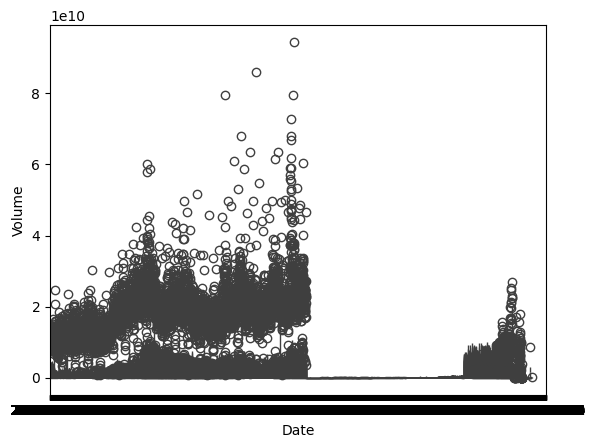

In [ ]:
# Let's also make the same barplot as before

sns.boxplot(x=clean_df['Date'], y=clean_df['Volume'])

Looks like we either introduced some NaN values, or they were there before and we are only now able to see them, let's check how many values we have

In [ ]:
print(clean_df.isnull().sum())

Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64


We can afford to drop them, so let's go ahead

In [ ]:
def drop_nan_values(df: pd.DataFrame) -> pd.DataFrame:
  """
  Drops rows from the DataFrame that contain NaN (Not a Number) values in any column.

  This function efficiently removes any row in the input DataFrame that has at least
  one NaN value. This is a common data cleaning step to ensure that machine learning
  models are trained on complete data.

  Args:
    df (pd.DataFrame): The input DataFrame that may contain NaN values.

  Returns:
    pd.DataFrame: A new DataFrame with rows containing NaN values removed.
                  Returns a copy of the DataFrame with NaN rows dropped; the original DataFrame is not modified.
  """
  full_df = df.dropna().copy() # Use dropna() to remove rows with NaNs efficiently and create a copy
  return full_df

cleaner_df = drop_nan_values(clean_df)

In [ ]:
#Let's check for NaN values again
print(cleaner_df.isnull().sum())

Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
#Let's look into some more info
cleaner_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,68160.000000,68160.000000,68160.000000,68160.000000,68160.000000,6.816000e+04
mean,7649.330078,7695.840563,7596.432307,7648.235456,7648.026040,2.060733e+09
std,6174.152000,6208.194030,6133.361275,6171.872267,6172.011375,5.339244e+09
min,238.000000,238.399994,237.699997,238.100006,238.100006,1.000000e+02
25%,2403.092407,2418.807434,2384.533264,2403.179931,2403.104919,1.785225e+06
50%,6843.819824,6886.599853,6788.415039,6838.425049,6838.412110,1.027414e+08
75%,10769.785160,10825.682372,10705.840085,10768.712400,10768.682370,1.559118e+09
max,33335.480470,33484.078130,32897.039060,33154.121090,33154.121090,9.440374e+10


As discussed before, we know that XGB are very robust and not so sensible to outliers, so we will keep these original values and see if we are happy with the outcome or not. If not, we'll feature engineer some more and see if it makes any difference.

For now, let's modify a bit more the dataframe, by creating lag features and using the Date row as index.

In [ ]:
def create_date_index(df):
  """
  Converts the 'Date' column to datetime objects and sets it as the DataFrame's index.

  This function takes a Pandas DataFrame as input, assumes it has a column named 'Date'
  containing date or datetime information, and performs the following steps:

  1. Converts the 'Date' column to Pandas datetime objects using pd.to_datetime().
  2. Sets the DataFrame's index to be the 'Date' column.
  3. Drops the original 'Date' column from the DataFrame as it is now the index.
  4. Returns a copy of the modified DataFrame.

  This is a common preprocessing step for time series data, as having a DatetimeIndex
  allows for time-based indexing and time series-specific operations in Pandas.

  Args:
    df (pd.DataFrame): The input DataFrame. It is expected to have a column named 'Date'
                       that can be converted to datetime objects.

  Returns:
    pd.DataFrame: A new DataFrame with the 'Date' column converted to a DatetimeIndex
                  and the original 'Date' column removed. Returns a copy, so the
                  original DataFrame is not modified.
  """
  df['Date'] = pd.to_datetime(df['Date'])
  df.index = df['Date']
  df = df.drop('Date', axis=1).copy()
  return df

cleaner_df = create_date_index(cleaner_df)
cleaner_df

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2001-01-03,NYA,6968.830078,6968.830078,6968.830078,6968.830078,6968.830078,1.880700e+09
2001-01-04,NYA,6894.810059,6894.810059,6894.810059,6894.810059,6894.810059,2.169400e+09
2001-01-05,NYA,6774.060059,6774.060059,6774.060059,6774.060059,6774.060059,1.430800e+09
2001-01-08,NYA,6759.049805,6759.049805,6759.049805,6759.049805,6759.049805,1.115500e+09
2001-01-09,NYA,6754.819824,6754.819824,6754.819824,6754.819824,6754.819824,1.191300e+09
...,...,...,...,...,...,...,...
2021-05-27,N100,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,3.796964e+08
2021-05-28,N100,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,1.607734e+08
2021-05-31,N100,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,9.117370e+07


In [ ]:
#Let's create lag features from the date column

def extract_date_features(df: pd.DataFrame) -> pd.DataFrame:
  """
  Extracts day, month, and year as new columns from the DataFrame's DatetimeIndex.

  This function assumes that the input DataFrame has a DatetimeIndex. It creates three
  new columns: 'Day', 'Month', and 'Year', containing the day of the month, the month number,
  and the year, respectively, extracted from the DatetimeIndex.

  Args:
    df (pd.DataFrame): The input DataFrame with a DatetimeIndex.

  Returns:
    pd.DataFrame: A new DataFrame with added 'Day', 'Month', and 'Year' columns.
                  Returns a copy of the DataFrame with the new columns added; the original DataFrame is not modified.
  """
  df = df.copy() # Create a copy to avoid modifying the original DataFrame
  df['Day'] = df.index.day
  df['Month'] = df.index.month
  df['Year'] = df.index.year
  return df

cleaner_df = extract_date_features(cleaner_df)

In [ ]:
cleaner_df

,Index,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
Date,,,,,,,,,,
2001-01-03,NYA,6968.830078,6968.830078,6968.830078,6968.830078,6968.830078,1.880700e+09,3,1,2001
2001-01-04,NYA,6894.810059,6894.810059,6894.810059,6894.810059,6894.810059,2.169400e+09,4,1,2001
2001-01-05,NYA,6774.060059,6774.060059,6774.060059,6774.060059,6774.060059,1.430800e+09,5,1,2001
2001-01-08,NYA,6759.049805,6759.049805,6759.049805,6759.049805,6759.049805,1.115500e+09,8,1,2001
2001-01-09,NYA,6754.819824,6754.819824,6754.819824,6754.819824,6754.819824,1.191300e+09,9,1,2001
...,...,...,...,...,...,...,...,...,...,...
2021-05-27,N100,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,3.796964e+08,27,5,2021
2021-05-28,N100,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,1.607734e+08,28,5,2021
2021-05-31,N100,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,9.117370e+07,31,5,2021


One more step and then we can go into training the model.

The Ticker column is named 'Index', we'll change that into 'Ticker' and we'll create categorical values from that column

In [ ]:
import pandas as pd

def process_ticker_column(df: pd.DataFrame) -> pd.DataFrame:
  """
  Renames the 'Index' column to 'Ticker' and converts the 'Ticker' column to categorical data type.

  This function takes a Pandas DataFrame as input and performs two transformations
  on the column that is assumed to represent stock tickers (currently named 'Index'):

  1. Renames the column 'Index' to 'Ticker'.
  2. Converts the 'Ticker' column to the Pandas categorical data type. This is often
     useful for columns that represent categories or identifiers, as it can save memory
     and may be beneficial for certain machine learning models.

  Args:
    df (pd.DataFrame): The input DataFrame. It is expected to have a column named 'Index'
                       that represents stock tickers or similar identifiers.

  Returns:
    pd.DataFrame: A new DataFrame with the 'Index' column renamed to 'Ticker' and
                  the 'Ticker' column converted to categorical type.
                  Returns a copy of the DataFrame with the changes applied; the original DataFrame is not modified.
  """
  df_processed = df.copy() # Create a copy to avoid modifying the original DataFrame
  df_processed = df_processed.rename(columns={'Index': 'Ticker'}) # Rename 'Index' to 'Ticker'
  df_processed = pd.get_dummies(df_processed) # Convert 'Ticker' to categorical
  return df_processed

df = process_ticker_column(cleaner_df)

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,Ticker_000001.SS,...,Ticker_GSPTSE,Ticker_HSI,Ticker_IXIC,Ticker_KS11,Ticker_N100,Ticker_N225,Ticker_NSEI,Ticker_NYA,Ticker_SSMI,Ticker_TWII
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-03,6968.830078,6968.830078,6968.830078,6968.830078,6968.830078,1.880700e+09,3,1,2001,False,...,False,False,False,False,False,False,False,True,False,False
2001-01-04,6894.810059,6894.810059,6894.810059,6894.810059,6894.810059,2.169400e+09,4,1,2001,False,...,False,False,False,False,False,False,False,True,False,False
2001-01-05,6774.060059,6774.060059,6774.060059,6774.060059,6774.060059,1.430800e+09,5,1,2001,False,...,False,False,False,False,False,False,False,True,False,False
2001-01-08,6759.049805,6759.049805,6759.049805,6759.049805,6759.049805,1.115500e+09,8,1,2001,False,...,False,False,False,False,False,False,False,True,False,False
2001-01-09,6754.819824,6754.819824,6754.819824,6754.819824,6754.819824,1.191300e+09,9,1,2001,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,3.796964e+08,27,5,2021,False,...,False,False,False,False,True,False,False,False,False,False
2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,1.607734e+08,28,5,2021,False,...,False,False,False,False,True,False,False,False,False,False
2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,9.117370e+07,31,5,2021,False,...,False,False,False,False,True,False,False,False,False,False


Let's now analyze the trend

<Axes: xlabel='Date', ylabel='Adj Close'>

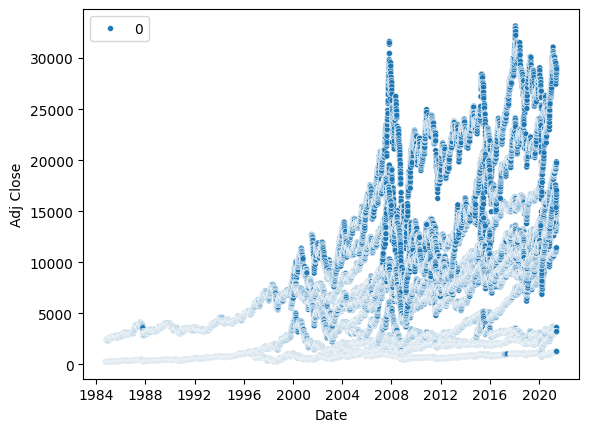

In [ ]:
sns.scatterplot(x=df.index, y=df['Adj Close'], size=0)

## **Data Pre-processing**

Let's create the target label, following these criterias:

 - 0) if the Adj Close is lower than the openining price
 - 1) if the Adj Close is higher than the openining price

In [ ]:
import pandas as pd
import numpy as np

def create_target_label(df: pd.DataFrame) -> pd.DataFrame:
  """
  Creates a binary target label column 'Target' in the DataFrame based on
  the relationship between 'Adj Close' and 'Open' prices.

  The function compares the 'Adj Close' price to the 'Open' price for each row
  in the input DataFrame and assigns a binary label to a new 'Target' column
  according to the following criteria:

  - If 'Adj Close' is lower than 'Open', the 'Target' label is set to 0.
  - If 'Adj Close' is higher than or equal to 'Open', the 'Target' label is set to 1.

  Args:
    df (pd.DataFrame): The input DataFrame. It is expected to have columns named
                       'Adj Close' and 'Open' representing adjusted closing price and
                       opening price respectively.

  Returns:
    pd.DataFrame: A new DataFrame with an added 'Target' column containing the binary
                  target labels (0 or 1). Returns a copy of the DataFrame with the
                  'Target' column added; the original DataFrame is not modified.
  """
  df_labeled = df.copy() # Create a copy to avoid modifying the original DataFrame
  df_labeled['Target'] = np.where(df_labeled['Adj Close'] < df_labeled['Open'], 0, 1)
  return df_labeled

df = create_target_label(df)
df[5000:]

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,Ticker_000001.SS,...,Ticker_HSI,Ticker_IXIC,Ticker_KS11,Ticker_N100,Ticker_N225,Ticker_NSEI,Ticker_NYA,Ticker_SSMI,Ticker_TWII,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-14,14445.360350,14459.650390,14214.030270,14214.929690,14214.929690,4.594920e+09,14,12,2020,False,...,False,False,False,False,False,False,True,False,False,0
2020-12-15,14303.030270,14410.150390,14271.360350,14402.320310,14402.320310,4.360280e+09,15,12,2020,False,...,False,False,False,False,False,False,True,False,False,1
2020-12-16,14426.080080,14442.889650,14370.509770,14408.940430,14408.940430,4.056950e+09,16,12,2020,False,...,False,False,False,False,False,False,True,False,False,0
2020-12-17,14488.690430,14519.990230,14472.190430,14516.730470,14516.730470,4.184930e+09,17,12,2020,False,...,False,False,False,False,False,False,True,False,False,1
2020-12-18,14525.740230,14529.879880,14394.349610,14467.820310,14467.820310,7.068340e+09,18,12,2020,False,...,False,False,False,False,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,3.796964e+08,27,5,2021,False,...,False,False,False,True,False,False,False,False,False,1
2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,1.607734e+08,28,5,2021,False,...,False,False,False,True,False,False,False,False,False,1
2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,9.117370e+07,31,5,2021,False,...,False,False,False,True,False,False,False,False,False,0


In [ ]:
#Let's check the distribution of the class labels to help us choose the best metric later on when deciding the model

print(f"Target 0: {len(df[df['Target'] == 0])}, Target 1: {len(df[df['Target'] == 1])}")

Target 0: 32989, Target 1: 35171


~ Equal distribution, accuracy will still do the trick, let's now implement lagged features inside of our dataframe

In [ ]:
def create_lagged_features_v2(df, lags=5, columns_to_lag=['Adj Close', 'Volume']): # Modified function
    """
    Creates lagged features for specified columns in the DataFrame.

    This function creates lagged features for the columns listed in 'columns_to_lag'.
    For each column and each lag period (from 1 to 'lags'), it creates a new column
    with the lagged values.

    Args:
        df (pd.DataFrame): The input DataFrame.
        lags (int): The maximum number of lags to create (e.g., lags=5 will create lag_1, lag_2, ..., lag_5).
        columns_to_lag (list of str): A list of column names for which to create lagged features.
                                       Defaults to ['Adj Close', 'Volume'].

    Returns:
        pd.DataFrame: A new DataFrame with added lagged features. Rows with NaN values
                      resulting from the shifting operation are removed.
                      Returns a copy of the DataFrame with the new columns added; the original DataFrame is not modified.
    """
    df_lagged = df.copy()
    for col in columns_to_lag:
        for lag in range(1, lags + 1):
            df_lagged[f'{col}_lag_{lag}'] = df_lagged[col].shift(lag)
    df_lagged = df_lagged.dropna() # Remove rows with NaN due to shifting
    return df_lagged

In [ ]:
df[5000:]

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year,Ticker_000001.SS,...,Ticker_HSI,Ticker_IXIC,Ticker_KS11,Ticker_N100,Ticker_N225,Ticker_NSEI,Ticker_NYA,Ticker_SSMI,Ticker_TWII,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-14,14445.360350,14459.650390,14214.030270,14214.929690,14214.929690,4.594920e+09,14,12,2020,False,...,False,False,False,False,False,False,True,False,False,0
2020-12-15,14303.030270,14410.150390,14271.360350,14402.320310,14402.320310,4.360280e+09,15,12,2020,False,...,False,False,False,False,False,False,True,False,False,1
2020-12-16,14426.080080,14442.889650,14370.509770,14408.940430,14408.940430,4.056950e+09,16,12,2020,False,...,False,False,False,False,False,False,True,False,False,0
2020-12-17,14488.690430,14519.990230,14472.190430,14516.730470,14516.730470,4.184930e+09,17,12,2020,False,...,False,False,False,False,False,False,True,False,False,1
2020-12-18,14525.740230,14529.879880,14394.349610,14467.820310,14467.820310,7.068340e+09,18,12,2020,False,...,False,False,False,False,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,3.796964e+08,27,5,2021,False,...,False,False,False,True,False,False,False,False,False,1
2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,1.607734e+08,28,5,2021,False,...,False,False,False,True,False,False,False,False,False,1
2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,9.117370e+07,31,5,2021,False,...,False,False,False,True,False,False,False,False,False,0


In [ ]:
df_ready = create_lagged_features_v2(df).drop(['Close', 'Adj Close'], axis=1)

small_df = df_ready[1000:2000] #index up to 999 (starting from 0)
small_df

,Open,High,Low,Volume,Day,Month,Year,Ticker_000001.SS,Ticker_399001.SZ,Ticker_GDAXI,...,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-05,7090.520020,7103.520020,7055.089844,1.736800e+09,5,1,2005,False,False,False,...,7090.520020,7179.709961,7250.060059,7253.560059,7242.240234,1.721000e+09,1.505900e+09,7.869000e+08,8.298000e+08,9.259000e+08
2005-01-06,7055.220215,7095.990234,7052.819824,1.569100e+09,6,1,2005,False,False,False,...,7055.209961,7090.520020,7179.709961,7250.060059,7253.560059,1.736800e+09,1.721000e+09,1.505900e+09,7.869000e+08,8.298000e+08
2005-01-07,7076.939941,7102.790039,7039.410156,1.477900e+09,7,1,2005,False,False,False,...,7076.939941,7055.209961,7090.520020,7179.709961,7250.060059,1.569100e+09,1.736800e+09,1.721000e+09,1.505900e+09,7.869000e+08
2005-01-10,7057.509766,7106.970215,7055.540039,1.489900e+09,10,1,2005,False,False,False,...,7057.509766,7076.939941,7055.209961,7090.520020,7179.709961,1.477900e+09,1.569100e+09,1.736800e+09,1.721000e+09,1.505900e+09
2005-01-11,7081.709961,7081.709961,7037.080078,1.488600e+09,11,1,2005,False,False,False,...,7081.700195,7057.509766,7076.939941,7055.209961,7090.520020,1.489900e+09,1.477900e+09,1.569100e+09,1.736800e+09,1.721000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-30,5534.680176,5670.729980,5534.680176,3.627800e+09,30,12,2008,False,False,False,...,5534.640137,5538.189941,5487.330078,5468.279785,5520.819824,3.323430e+09,1.880050e+09,1.546550e+09,4.051970e+09,4.869850e+09
2008-12-31,5670.000000,5793.540039,5660.669922,4.172940e+09,31,12,2008,False,False,False,...,5670.000000,5534.640137,5538.189941,5487.330078,5468.279785,3.627800e+09,3.323430e+09,1.880050e+09,1.546550e+09,4.051970e+09
2009-01-02,5755.759766,5937.020020,5732.680176,4.048270e+09,2,1,2009,False,False,False,...,5757.049805,5670.000000,5534.640137,5538.189941,5487.330078,4.172940e+09,3.627800e+09,3.323430e+09,1.880050e+09,1.546550e+09


## Train/Val/Test split

In [ ]:
splitter = TimeSeriesSplit(n_splits=3)

#We will not create the X and y label now, but we'll do it later when training on the full dataset
#We'll create a different test dataframe, 20% of the size of the total df


small_train = small_df.iloc[:800]
small_test = small_df.iloc[800:]

#Let's always print the results
print(f"""
Small train size: {small_train.shape},
Small test size: {small_test.shape},
Last train feature: {small_train[-1:]},
First test feature: {small_test[:1]},
""")


Small train size: (800, 31),
Small test size: (200, 31),
Last train feature:                    Open         High          Low        Volume  Day  Month  \
Date                                                                          
2008-03-20  8549.509766  8728.259766  8494.620117  6.145220e+09   20      3   

            Year  Ticker_000001.SS  Ticker_399001.SZ  Ticker_GDAXI  ...  \
Date                                                                ...   
2008-03-20  2008             False             False         False  ...   

            Adj Close_lag_1  Adj Close_lag_2  Adj Close_lag_3  \
Date                                                            
2008-03-20           8549.5       8826.44043      8489.379883   

            Adj Close_lag_4  Adj Close_lag_5  Volume_lag_1  Volume_lag_2  \
Date                                                                       
2008-03-20      8635.919922      8827.160156  5.358550e+09  5.335630e+09   

            Volume_lag_3  Volume_

In [ ]:
small_test[100:]

,Open,High,Low,Volume,Day,Month,Year,Ticker_000001.SS,Ticker_399001.SZ,Ticker_GDAXI,...,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-14,8375.330078,8412.599609,8303.540039,4.064000e+09,14,8,2008,False,False,False,...,8375.389648,8398.709961,8492.940430,8460.320313,8338.400391,4.787600e+09,4.711290e+09,5.067310e+09,4.966810e+09,5.319380e+09
2008-08-15,8385.849609,8407.290039,8338.839844,4.041820e+09,15,8,2008,False,False,False,...,8385.969727,8375.389648,8398.709961,8492.940430,8460.320313,4.064000e+09,4.787600e+09,4.711290e+09,5.067310e+09,4.966810e+09
2008-08-18,8383.790039,8413.530273,8259.969727,3.829290e+09,18,8,2008,False,False,False,...,8383.669922,8385.969727,8375.389648,8398.709961,8492.940430,4.041820e+09,4.064000e+09,4.787600e+09,4.711290e+09,5.067310e+09
2008-08-19,8281.809570,8281.809570,8180.879883,4.159760e+09,19,8,2008,False,False,False,...,8281.860352,8383.669922,8385.969727,8375.389648,8398.709961,3.829290e+09,4.041820e+09,4.064000e+09,4.787600e+09,4.711290e+09
2008-08-20,8212.459961,8278.639648,8187.370117,4.555030e+09,20,8,2008,False,False,False,...,8212.469727,8281.860352,8383.669922,8385.969727,8375.389648,4.159760e+09,3.829290e+09,4.041820e+09,4.064000e+09,4.787600e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-30,5534.680176,5670.729980,5534.680176,3.627800e+09,30,12,2008,False,False,False,...,5534.640137,5538.189941,5487.330078,5468.279785,5520.819824,3.323430e+09,1.880050e+09,1.546550e+09,4.051970e+09,4.869850e+09
2008-12-31,5670.000000,5793.540039,5660.669922,4.172940e+09,31,12,2008,False,False,False,...,5670.000000,5534.640137,5538.189941,5487.330078,5468.279785,3.627800e+09,3.323430e+09,1.880050e+09,1.546550e+09,4.051970e+09
2009-01-02,5755.759766,5937.020020,5732.680176,4.048270e+09,2,1,2009,False,False,False,...,5757.049805,5670.000000,5534.640137,5538.189941,5487.330078,4.172940e+09,3.627800e+09,3.323430e+09,1.880050e+09,1.546550e+09


# **Model**

---

As per standard precidures, let's start creating ranges of parameters that we'll want to try out when looking for the best model.

The parameters we'll work with are:

  - n_estimators (the number of trees in the ensemble);
  - learning_rate;
  - reg_lambda (regularization parameter);
  - max_depth (how many relations shouls our tree learn)

We'll be using RandomSearchCV to make this easier

In [ ]:
#Let's instatiate a list in which we'll kee the best parameters for comparison at the end

best_params = []

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribution = {
    'n_estimators': [40, 50, 60, 70, 80, 100],
    'learning_rate': [0.05, 0.1, 0.5, 1, 2],
    'reg_lambda': [0.1, 0.5, 1, 2, 4, 8, 10],
    'max_depth': range(8)
}

scores = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

randomgrid1 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution,
    n_iter=200,
    scoring=scores,
    refit='accuracy',
    cv=splitter,
    return_train_score=True,
).fit(small_train.drop('Target', axis=1), small_train['Target'])

best_params.append({
    'Parameters': randomgrid1.best_params_,
    'Accuracy score': randomgrid1.best_score_
})

In [ ]:
randomgrid1.best_params_, randomgrid1.best_score_

({'reg_lambda': 0.5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 2},
 np.float64(0.5616666666666666))

Let's now print our differnt models and find the best one

In [ ]:
for model in best_params:
  params = model.get('Parameters')
  acc_score = model.get('Accuracy score')
  print(f'Parameters: {params}, Accuracy: {acc_score}')

Parameters: {'reg_lambda': 0.5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 2}, Accuracy: 0.5616666666666666


Based on my runs, I got pretty similar accuracy scores, and different models in complexity, let's now plot the feature importances and add some more matrics and parameters for the CV searcha nd hope to find a better model.

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix

param_distribution = {
    'n_estimators': [50, 100, 200, 300, 400, 500], # Wider range of estimators
    'max_depth': [3, 4, 5, 6, 7, 8], # Slightly wider range of depths
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # Explore smaller learning rates
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Subsampling rows
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # Subsampling columns
    'gamma': [0, 0.1, 0.2, 0.3, 0.4], # Regularization parameter gamma
    'reg_alpha': [0, 0.1, 0.5, 1, 5], # L1 regularization
    'reg_lambda': [0.1, 1, 5, 10], # L2 regularization
    'min_child_weight': [1, 3, 5, 7], # min_child_weight
    'objective': ['binary:logistic'],
    'random_state': [42]
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
}

randomsearch2 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    cv=splitter,
    n_iter=10
).fit(small_train.drop('Target', axis=1), small_train['Target'])

In [ ]:
randomsearch2.best_score_

np.float64(0.525)

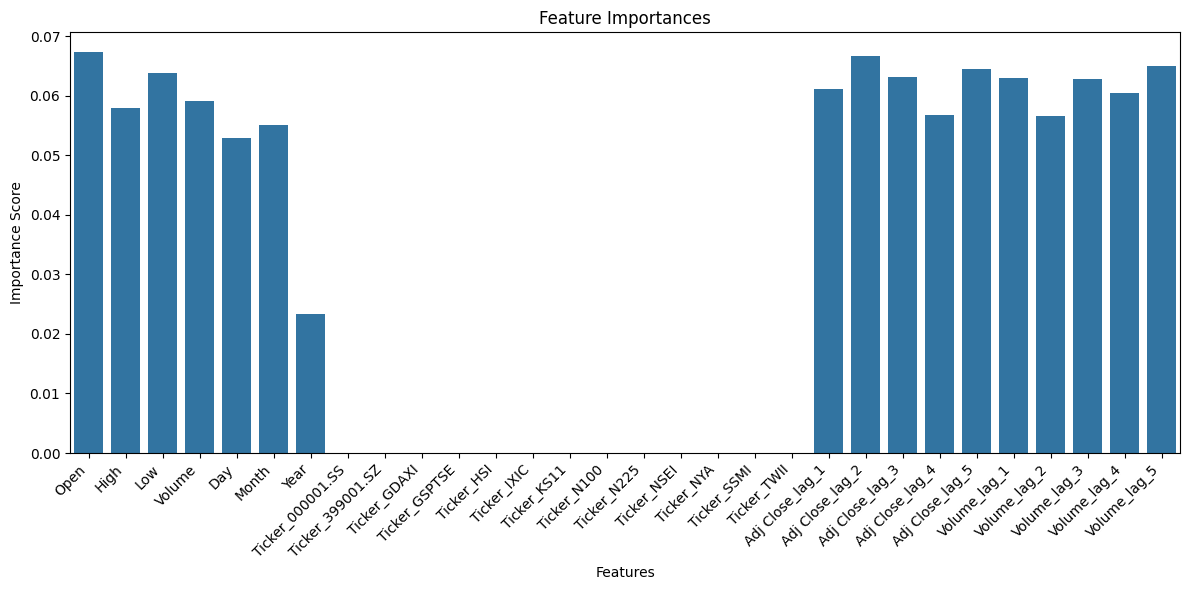

In [ ]:
feature_names = small_train.drop("Target", axis=1).columns
importances = randomsearch2.best_estimator_.feature_importances_

def plot_figure_importance(importances, feature_names):
  plt.figure(figsize=(12, 6))  # Adjust figure size as needed
  barplot = sns.barplot(x=feature_names, y=importances)
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels by 45 degrees, horizontal alignment 'right'
  plt.title('Feature Importances')
  plt.xlabel('Features')
  plt.ylabel('Importance Score')
  plt.tight_layout() # Adjust layout to prevent labels from being cut off
  plt.show()

plot_figure_importance(importances, feature_names)

Judging from the feature importances:

 - I will refrain from the deleting the 'useless' features for the moment;
 - I will create more lagged features for the non-lagged important features

In [ ]:
small_train = create_lagged_features_v2(small_train, lags=5, columns_to_lag=['Open', 'High', 'Low'])
small_train

,Open,High,Low,Volume,Day,Month,Year,Ticker_000001.SS,Ticker_399001.SZ,Ticker_GDAXI,...,High_lag_1,High_lag_2,High_lag_3,High_lag_4,High_lag_5,Low_lag_1,Low_lag_2,Low_lag_3,Low_lag_4,Low_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-12,7044.109863,7076.850098,7016.839844,1.562100e+09,12,1,2005,False,False,False,...,7081.709961,7106.970215,7102.790039,7095.990234,7103.520020,7037.080078,7055.540039,7039.410156,7052.819824,7055.089844
2005-01-13,7075.629883,7075.779785,7021.899902,1.510300e+09,13,1,2005,False,False,False,...,7076.850098,7081.709961,7106.970215,7102.790039,7095.990234,7016.839844,7037.080078,7055.540039,7039.410156,7052.819824
2005-01-14,7028.680176,7069.620117,7028.029785,1.335400e+09,14,1,2005,False,False,False,...,7075.779785,7076.850098,7081.709961,7106.970215,7102.790039,7021.899902,7016.839844,7037.080078,7055.540039,7039.410156
2005-01-18,7066.209961,7114.529785,7036.700195,1.594700e+09,18,1,2005,False,False,False,...,7069.620117,7075.779785,7076.850098,7081.709961,7106.970215,7028.029785,7021.899902,7016.839844,7037.080078,7055.540039
2005-01-19,7114.509766,7115.879883,7058.060059,1.498700e+09,19,1,2005,False,False,False,...,7114.529785,7069.620117,7075.779785,7076.850098,7081.709961,7036.700195,7028.029785,7021.899902,7016.839844,7037.080078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-14,8827.080078,8845.830078,8553.639648,5.153780e+09,14,3,2008,False,False,False,...,8857.639648,8917.459961,8842.690430,8683.290039,8802.570313,8608.950195,8776.809570,8534.480469,8524.700195,8610.200195
2008-03-17,8634.360352,8634.419922,8362.669922,5.683010e+09,17,3,2008,False,False,False,...,8845.830078,8857.639648,8917.459961,8842.690430,8683.290039,8553.639648,8608.950195,8776.809570,8534.480469,8524.700195
2008-03-18,8489.389648,8826.440430,8489.389648,5.335630e+09,18,3,2008,False,False,False,...,8634.419922,8845.830078,8857.639648,8917.459961,8842.690430,8362.669922,8553.639648,8608.950195,8776.809570,8534.480469


In [ ]:
#Let's re-run the random search

randomsearch3 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    cv=splitter,
    n_iter=300
).fit(small_train.drop('Target', axis=1), small_train['Target'])

In [ ]:
randomsearch3.best_score_

np.float64(0.5589225589225589)

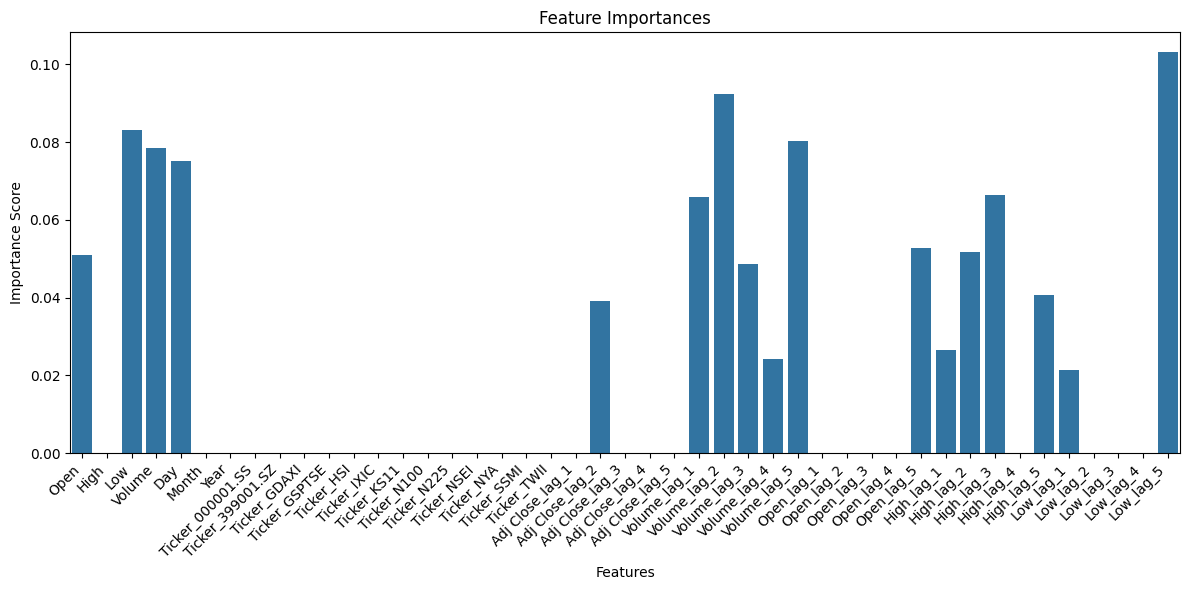

In [ ]:
plot_figure_importance(
    importances=randomsearch3.best_estimator_.feature_importances_,
    feature_names=small_train.drop('Target', axis=1).columns
)

Model keeps giving a very bad accuracy score, this makes me wonder if this is the best metric in order to find the best model or not.
To test this, we'll create a funtion to pass in the RandomizedSearchCV with which we'll find the best index of the scores based on the average of all the metrics used for evaluation, we'll also implement into the scroing metrics precisions and recall

In [ ]:
def find_best_index_overall_scores(cv_results):
    """
    Finds the index of the best parameter set from RandomizedSearchCV cv_results_
    based on the best overall score, which is the average of mean test scores
    across all evaluated scoring metrics.

    Args:
        cv_results (dict): The cv_results_ dictionary from RandomizedSearchCV.

    Returns:
        int: The index (best_index_) of the best parameter set in cv_results_
             based on the overall score.
             Returns None if no 'mean_test_' metrics are found in cv_results_.
    """
    mean_test_score_metrics = [key for key in cv_results.keys() if key.startswith('mean_test_')]

    if not mean_test_score_metrics:
        print("No 'mean_test_' metrics found in cv_results_. Please ensure you provided scoring metrics in RandomizedSearchCV.")
        return None

    overall_scores = np.mean([cv_results[metric] for metric in mean_test_score_metrics], axis=0) # Average across metrics for each parameter set
    best_index = np.argmax(overall_scores) # Find index with highest overall average score
    return best_index

In [ ]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1score': make_scorer(f1_score),
    'recall': make_scorer(skm.recall_score),
    'map': make_scorer(skm.precision_score),
    'roc_auc': make_scorer(roc_auc_score)

}

randomsearch4 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution,
    scoring=scoring,
    refit=find_best_index_overall_scores,
    return_train_score=True,
    cv=splitter,
    n_iter=300
).fit(small_train.drop('Target', axis=1), small_train['Target'])

In [ ]:
randomsearch4.cv_results_

{'mean_fit_time': array([0.95400318, 0.39563314, 0.14654048, 0.46610538, 0.5494531 ,
        0.40858992, 0.06455016, 0.05161858, 0.24449976, 1.2397577 ,
        0.34408545, 0.56324244, 0.09390251, 0.22668068, 0.18787543,
        0.29137071, 0.17551112, 0.81076606, 0.82952833, 0.09611249,
        0.3336792 , 0.33079632, 0.16046453, 0.10034625, 0.12332058,
        0.4568193 , 0.50469557, 0.18454035, 0.09646877, 0.25753919,
        0.74583403, 0.21300109, 0.05722475, 0.40081056, 0.17862415,
        0.50427572, 0.11028663, 0.11973675, 0.41163913, 0.60513703,
        0.73168548, 0.28009629, 0.37767132, 0.13312403, 0.45671725,
        0.1363376 , 0.31584334, 0.19990102, 0.13270497, 0.23269288,
        0.26263738, 0.07241551, 0.42673969, 0.6070586 , 0.42008718,
        0.12656037, 0.15695055, 0.09972143, 0.41061187, 0.07449905,
        0.12818472, 0.45268329, 0.07771071, 0.22294005, 0.37902276,
        1.17608213, 0.06809815, 0.10325376, 0.12199966, 0.07856719,
        0.3426954 , 0.06489023,

Sorry for shitty formatting, but looking at cv_results we see an overfitting problem, let's try and modify the param_distributions by keeping this in mind

In [ ]:
param_distribution = {
    'n_estimators': [50, 100, 150, 200],  # Reduced max n_estimators
    'max_depth': [3, 4, 5, 6], # Shallower trees - reduced max depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Keep exploring learning rates
    'subsample': [0.6, 0.7, 0.8, 0.9], # Subsampling rows - keep exploring
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8], # Subsampling columns - keep exploring
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1], # Increased gamma range - stronger pruning
    'reg_alpha': [0.1, 0.5, 1, 2, 5, 10], # Increased reg_alpha range - stronger L1
    'reg_lambda': [1, 2, 5, 10, 20], # Increased reg_lambda range - stronger L2
    'min_child_weight': [1, 3, 5, 8, 12], # min_child_weight - keep exploring
    'objective': ['binary:logistic'],
    'eval_metric': ['map', 'logloss', 'auc', 'pre'],
    'random_state': [42]
}

randomsearch5 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution,
    scoring=scoring,
    refit='recall',
    return_train_score=True,
    cv=splitter,
    n_iter=10,
).fit(small_train.drop('Target', axis=1), small_train['Target'])

In [ ]:
randomsearch5.best_score_

np.float64(0.7316384687074341)

In [ ]:
randomsearch5.best_params_

{'subsample': 0.9,
 'reg_lambda': 1,
 'reg_alpha': 5,
 'random_state': 42,
 'objective': 'binary:logistic',
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'eval_metric': 'auc',
 'colsample_bytree': 0.7}

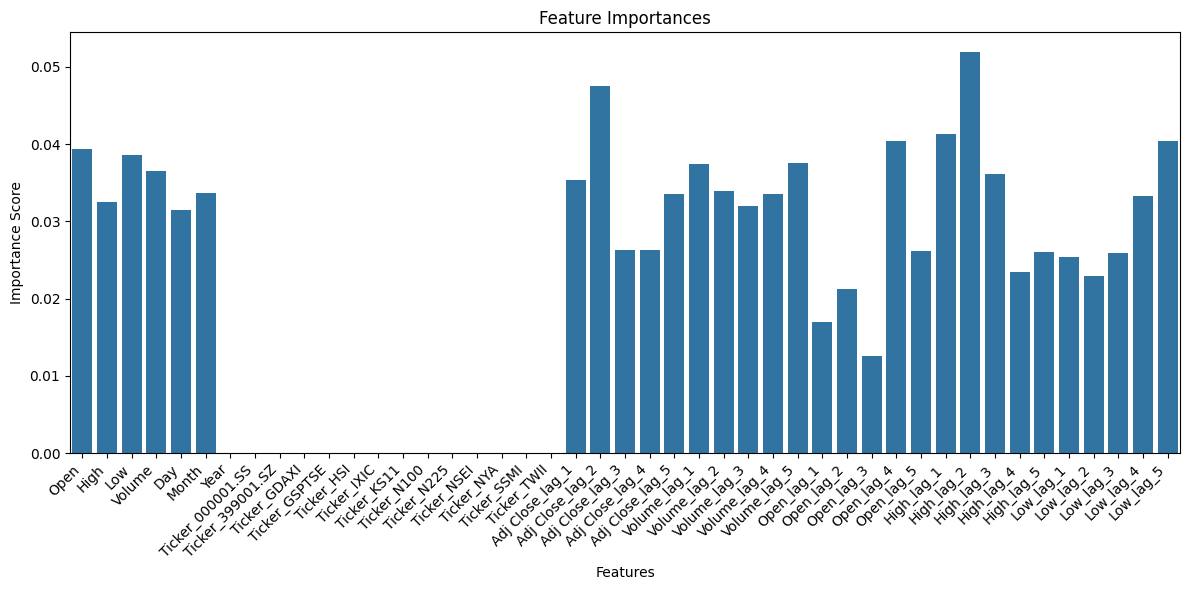

In [ ]:
plot_figure_importance(importances=randomsearch5.best_estimator_.feature_importances_,
                        feature_names=small_train.drop("Target",axis=1).columns)

To address the overfitting instance, let's create less lag features and create another param_distribution to cover a large range of values

In [ ]:
#let's remove the lag features and only keep the original ones
small_train_lf = create_lagged_features_v2(df[1000:2000], lags=2, columns_to_lag=['Volume', 'Adj Close', 'Open', 'Low', 'High'])
small_train_lf = create_target_label(small_train_lf)
small_train_lf = small_train_lf.drop(['Close', 'Adj Close'], axis=1)

In [ ]:
param_distribution_revised = {
    'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3], # Focus on smaller learning rates
    'max_depth': range(3, 8), # Shallower trees (max depth up to 7)
    'reg_lambda': [1, 2, 4, 6, 8, 10, 15, 20, 30, 40, 50, 70],
    'reg_alpha': [1, 2, 4, 6, 8, 10, 15, 20, 30, 40, 50, 70],
    'gamma': [1, 5, 10, 15, 20, 30, 40, 50, 70],
    'min_child_weight': [8, 12, 15],
    'n_estimators': [50, 100, 150], # Reduced max n_estimators
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8],
    'objective': ['binary:logistic'],
    'eval_metric': ['map', 'logloss', 'auc', 'pre'],
    'random_state': [42]
}

randomsearch5 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution_revised,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    cv=splitter,
    n_iter=100,
).fit(small_train_lf.drop('Target', axis=1), small_train_lf['Target'])

In [ ]:
def print_mean_train_test_errors(cv_results):
    """
    Iterates through cv_results_ dictionary from RandomizedSearchCV or GridSearchCV
    and prints the mean train and test scores for each evaluation metric.

    Args:
        cv_results (dict): The cv_results_ dictionary from GridSearchCV or RandomizedSearchCV.
    """
    print("Mean Train and Test Scores for Each Metric:")
    print("-" * 50)
    for metric in cv_results:
        if metric.startswith('mean_train_'):
            test_metric_name = metric.replace('mean_train_', 'mean_test_')
            if test_metric_name in cv_results:
                train_scores_mean = cv_results[metric]
                test_scores_mean = cv_results[test_metric_name]
                metric_name_display = metric.replace('mean_train_', '').replace('_', ' ').strip() # Clean up metric name for display
                print(f"Metric: {metric_name_display}")
                print(f"  Mean Train Score: {train_scores_mean.mean():.4f}") # Take mean if it's array, format to 4 decimal places
                print(f"  Mean Test Score: {test_scores_mean.mean():.4f}")  # Take mean if it's array, format to 4 decimal places
                print("-" * 30)

print_mean_train_test_errors(randomsearch5.cv_results_)

Mean Train and Test Scores for Each Metric:
--------------------------------------------------
Metric: accuracy
  Mean Train Score: 0.5543
  Mean Test Score: 0.5332
------------------------------
Metric: f1score
  Mean Train Score: 0.7124
  Mean Test Score: 0.6939
------------------------------
Metric: recall
  Mean Train Score: 0.9992
  Mean Test Score: 0.9968
------------------------------
Metric: map
  Mean Train Score: 0.5537
  Mean Test Score: 0.5333
------------------------------
Metric: roc auc
  Mean Train Score: 0.5025
  Mean Test Score: 0.5003
------------------------------


In [ ]:
small_train_lf.columns

Index(['Open', 'High', 'Low', 'Volume', 'Day', 'Month', 'Year',
       'Ticker_000001.SS', 'Ticker_399001.SZ', 'Ticker_GDAXI', 'Ticker_GSPTSE',
       'Ticker_HSI', 'Ticker_IXIC', 'Ticker_KS11', 'Ticker_N100',
       'Ticker_N225', 'Ticker_NSEI', 'Ticker_NYA', 'Ticker_SSMI',
       'Ticker_TWII', 'Target', 'Volume_lag_1', 'Volume_lag_2',
       'Adj Close_lag_1', 'Adj Close_lag_2', 'Open_lag_1', 'Open_lag_2',
       'Low_lag_1', 'Low_lag_2', 'High_lag_1', 'High_lag_2'],
      dtype='object')

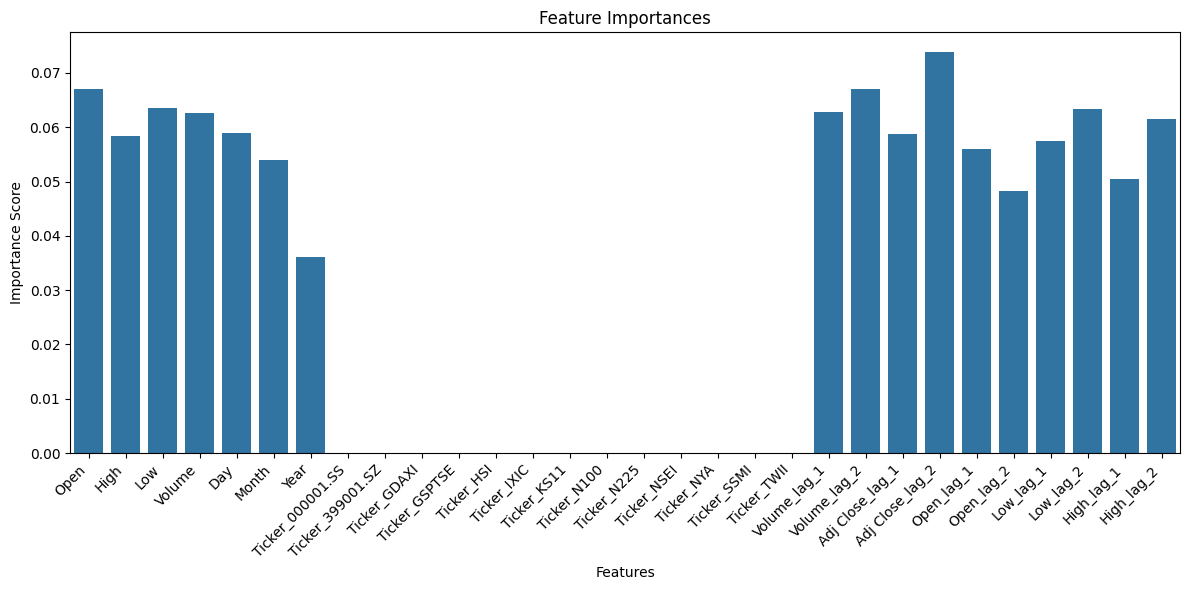

In [ ]:
plot_figure_importance(importances=randomsearch5.best_estimator_.feature_importances_,
                       feature_names=small_train_lf.drop('Target',axis=1).columns)

In [ ]:
def remove_ticker_columns(df):
  df = df.copy()
  col_to_remove = [col for col in df.columns if col.startswith('Ticker_')]
  df = df.drop(col_to_remove, axis=1)
  return df

small_train_no_ticker = remove_ticker_columns(small_train_lf)
small_train_no_ticker

,Open,High,Low,Volume,Day,Month,Year,Target,Volume_lag_1,Volume_lag_2,Adj Close_lag_1,Adj Close_lag_2,Open_lag_1,Open_lag_2,Low_lag_1,Low_lag_2,High_lag_1,High_lag_2
Date,,,,,,,,,,,,,,,,,,
2004-12-31,7253.560059,7273.180176,7248.750000,7.869000e+08,31,12,2004,0,8.298000e+08,9.259000e+08,7253.560059,7242.240234,7242.240234,7245.810059,7242.240234,7224.479980,7265.379883,7245.810059
2005-01-03,7250.060059,7268.209961,7174.000000,1.505900e+09,3,1,2005,0,7.869000e+08,8.298000e+08,7250.060059,7253.560059,7253.560059,7242.240234,7248.750000,7242.240234,7273.180176,7265.379883
2005-01-04,7179.709961,7191.240234,7084.149902,1.721000e+09,4,1,2005,0,1.505900e+09,7.869000e+08,7179.709961,7250.060059,7250.060059,7253.560059,7174.000000,7248.750000,7268.209961,7273.180176
2005-01-05,7090.520020,7103.520020,7055.089844,1.736800e+09,5,1,2005,0,1.721000e+09,1.505900e+09,7090.520020,7179.709961,7179.709961,7250.060059,7084.149902,7174.000000,7191.240234,7268.209961
2005-01-06,7055.220215,7095.990234,7052.819824,1.569100e+09,6,1,2005,1,1.736800e+09,1.721000e+09,7055.209961,7090.520020,7090.520020,7179.709961,7055.089844,7084.149902,7103.520020,7191.240234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-22,5616.120117,5622.600098,5432.549805,4.869850e+09,22,12,2008,0,6.705310e+09,5.675000e+09,5616.120117,5617.759766,5617.759766,5769.799805,5581.020020,5568.720215,5713.270020,5787.779785
2008-12-23,5520.819824,5573.740234,5447.120117,4.051970e+09,23,12,2008,0,4.869850e+09,6.705310e+09,5520.819824,5616.120117,5616.120117,5617.759766,5432.549805,5581.020020,5622.600098,5713.270020
2008-12-24,5468.279785,5496.089844,5444.979980,1.546550e+09,24,12,2008,1,4.051970e+09,4.869850e+09,5468.279785,5520.819824,5520.819824,5616.120117,5447.120117,5432.549805,5573.740234,5622.600098


In [ ]:
randomsearch6 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution_revised,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    cv=splitter,
    n_iter=100,
).fit(small_train_no_ticker.drop('Target', axis=1), small_train_no_ticker['Target'])

print_mean_train_test_errors(randomsearch6.cv_results_)

Mean Train and Test Scores for Each Metric:
--------------------------------------------------
Metric: accuracy
  Mean Train Score: 0.5555
  Mean Test Score: 0.5330
------------------------------
Metric: f1score
  Mean Train Score: 0.7132
  Mean Test Score: 0.6912
------------------------------
Metric: recall
  Mean Train Score: 0.9988
  Mean Test Score: 0.9912
------------------------------
Metric: map
  Mean Train Score: 0.5551
  Mean Test Score: 0.5338
------------------------------
Metric: roc auc
  Mean Train Score: 0.5039
  Mean Test Score: 0.5004
------------------------------


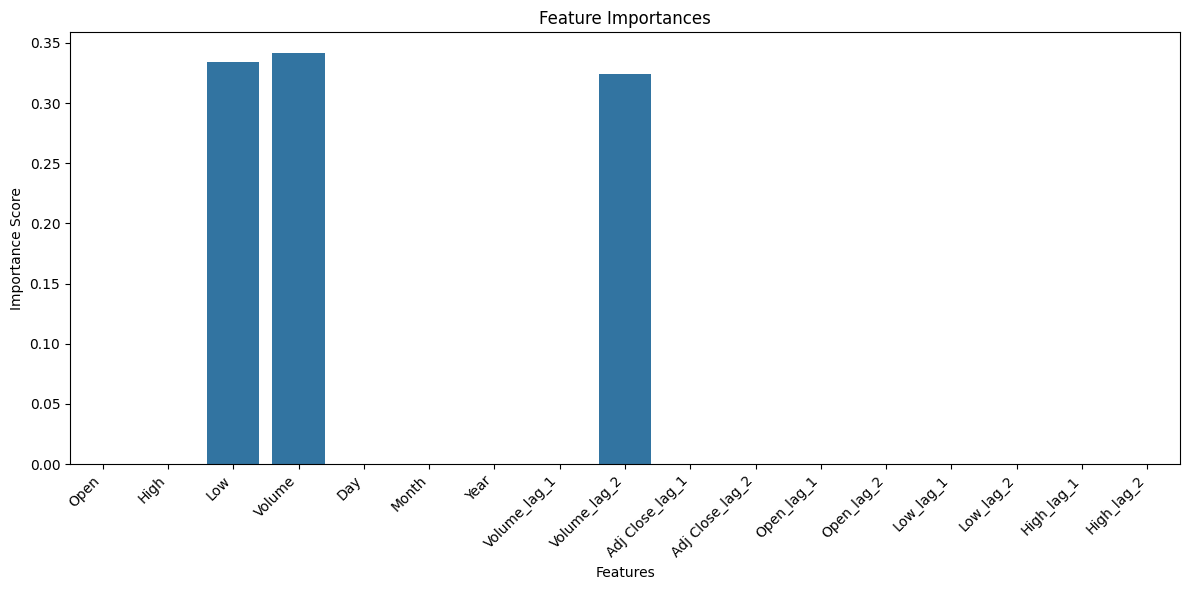

In [ ]:
plot_figure_importance(
  importances=randomsearch6.best_estimator_.feature_importances_,
  feature_names=small_train_no_ticker.drop("Target",axis=1).columns
)

Let's test one last time on the full dataset and see the results, if not optimal we'll switch to another model architecture

In [ ]:
df = create_lagged_features_v2(df, lags=3, columns_to_lag=['Open', 'High', 'Low', 'Close', 'Adj Close'])
df = remove_ticker_columns(df)
df = create_target_label(df)
df = df.drop(['Close', 'Adj Close'], axis=1)
df

,Open,High,Low,Volume,Day,Month,Year,Target,Open_lag_1,Open_lag_2,...,High_lag_3,Low_lag_1,Low_lag_2,Low_lag_3,Close_lag_1,Close_lag_2,Close_lag_3,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-08,6759.049805,6759.049805,6759.049805,1.115500e+09,8,1,2001,1,6774.060059,6894.810059,...,6968.830078,6774.060059,6894.810059,6968.830078,6774.060059,6894.810059,6968.830078,6774.060059,6894.810059,6968.830078
2001-01-09,6754.819824,6754.819824,6754.819824,1.191300e+09,9,1,2001,1,6759.049805,6774.060059,...,6894.810059,6759.049805,6774.060059,6894.810059,6759.049805,6774.060059,6894.810059,6759.049805,6774.060059,6894.810059
2001-01-10,6802.399902,6802.399902,6802.399902,1.296500e+09,10,1,2001,1,6754.819824,6759.049805,...,6774.060059,6754.819824,6759.049805,6774.060059,6754.819824,6759.049805,6774.060059,6754.819824,6759.049805,6774.060059
2001-01-11,6835.490234,6835.490234,6835.490234,1.411200e+09,11,1,2001,1,6802.399902,6754.819824,...,6759.049805,6802.399902,6754.819824,6759.049805,6802.399902,6754.819824,6759.049805,6802.399902,6754.819824,6759.049805
2001-01-12,6813.290039,6813.290039,6813.290039,1.276000e+09,12,1,2001,1,6835.490234,6802.399902,...,6754.819824,6835.490234,6802.399902,6754.819824,6835.490234,6802.399902,6754.819824,6835.490234,6802.399902,6754.819824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,1241.119995,1251.910034,1241.119995,3.796964e+08,27,5,2021,1,1247.119995,1247.650024,...,1244.010010,1241.199951,1243.670044,1238.459961,1243.420044,1243.739990,1243.900024,1243.420044,1243.739990,1243.900024
2021-05-28,1249.469971,1259.209961,1249.030029,1.607734e+08,28,5,2021,1,1241.119995,1247.119995,...,1249.339966,1241.119995,1241.199951,1243.670044,1247.069946,1243.420044,1243.739990,1247.069946,1243.420044,1243.739990
2021-05-31,1256.079956,1258.880005,1248.140015,9.117370e+07,31,5,2021,0,1249.469971,1241.119995,...,1248.640015,1249.030029,1241.119995,1241.199951,1256.599976,1247.069946,1243.420044,1256.599976,1247.069946,1243.420044


Mean Train and Test Scores for Each Metric:
--------------------------------------------------
Metric: accuracy
  Mean Train Score: 0.5555
  Mean Test Score: 0.5330
------------------------------
Metric: f1score
  Mean Train Score: 0.7132
  Mean Test Score: 0.6912
------------------------------
Metric: recall
  Mean Train Score: 0.9988
  Mean Test Score: 0.9912
------------------------------
Metric: map
  Mean Train Score: 0.5551
  Mean Test Score: 0.5338
------------------------------
Metric: roc auc
  Mean Train Score: 0.5039
  Mean Test Score: 0.5004
------------------------------


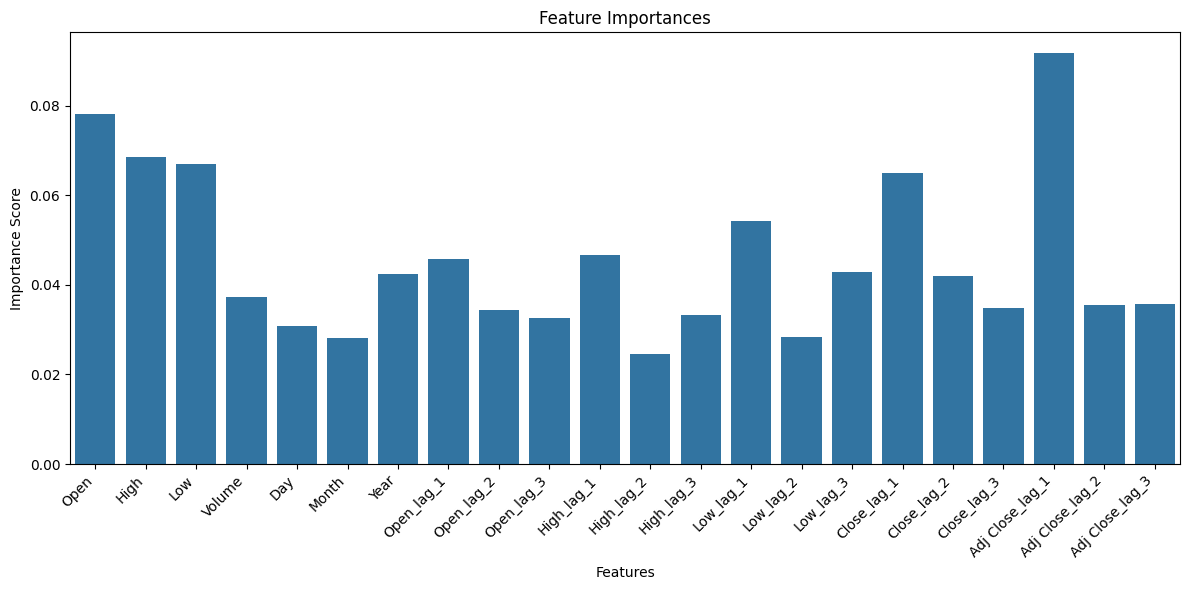

In [ ]:
randomsearch7 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    cv=splitter,
    n_iter=10,
).fit(df.drop('Target', axis=1), df['Target'])

print_mean_train_test_errors(randomsearch6.cv_results_)
plot_figure_importance(
    importances=randomsearch7.best_estimator_.feature_importances_,
    feature_names=df.drop("Target",axis=1).columns
)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

param_distribution_rf = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)], # Wide range of trees
    'max_depth': range(1, 10), # Range of depths and None for unlimited
    'min_samples_split': [2, 5, 10, 20], # Common values
    'min_samples_leaf': [15, 20, 30, 40, 50], # Common values
    'bootstrap': [True, False], # Both options for bootstrap
    'max_features': ['sqrt', 'log2'], # Different feature selection strategies
    'class_weight': ['balanced', 'balanced_subsample', None], # Options for class imbalance
    'criterion': ['gini', 'entropy'] # Impurity measures
}


cv_results_dummy = RandomizedSearchCV(
    estimator = RandomForestClassifier(),
    param_distributions=param_distribution_rf,
    cv=splitter,
    scoring=scoring,
    return_train_score=True,
    refit='accuracy'
).fit(df.drop("Target",axis=1), df['Target'])
print_mean_train_test_errors(cv_results_dummy.cv_results_)

Mean Train and Test Scores for Each Metric:
--------------------------------------------------
Metric: accuracy
  Mean Train Score: 0.5640
  Mean Test Score: 0.5105
------------------------------
Metric: f1score
  Mean Train Score: 0.6170
  Mean Test Score: 0.5557
------------------------------
Metric: recall
  Mean Train Score: 0.6857
  Mean Test Score: 0.6800
------------------------------
Metric: map
  Mean Train Score: 0.5866
  Mean Test Score: 0.5148
------------------------------
Metric: roc auc
  Mean Train Score: 0.5561
  Mean Test Score: 0.5090
------------------------------


In [ ]:
def engineer_technical_indicators(df, close_col='Close', high_col='High', low_col='Low', volume_col='Volume'):
    """
    Engineers common technical indicators into a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing financial data (at least close, high, low, volume).
        close_col (str): The name of the closing price column.
        high_col (str): The name of the high price column.
        low_col (str): The name of the low price column.
        volume_col (str): The name of the volume column.

    Returns:
        pd.DataFrame: The DataFrame with added technical indicator columns.
    """

    # Moving Averages
    df['SMA_5'] = df[close_col].rolling(window=5).mean()
    df['SMA_20'] = df[close_col].rolling(window=20).mean()
    df['EMA_12'] = df[close_col].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df[close_col].ewm(span=26, adjust=False).mean()

    # Volume and Momentum
    df['Volume_Change'] = df[volume_col].diff()

    def calculate_rsi(series, period=14):
        delta = series.diff(1)
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ma_up = up.rolling(window=period).mean()
        ma_down = down.rolling(window=period).mean()
        rsi = ma_up / ma_down
        rsi = 100 * (1 - (1 / (1 + rsi)))
        return rsi

    df['RSI'] = calculate_rsi(df[close_col])

    def calculate_macd(series, short_window=12, long_window=26, signal_window=9):
        short_ema = series.ewm(span=short_window, adjust=False).mean()
        long_ema = series.ewm(span=long_window, adjust=False).mean()
        macd = short_ema - long_ema
        signal = macd.ewm(span=signal_window, adjust=False).mean()
        return macd, signal

    df['MACD'], df['MACD_Signal'] = calculate_macd(df[close_col])

    return df

small_tech_features_df = engineer_technical_indicators(df[1000:2000])

KeyError: 'Close'

In [ ]:
small_tech_features_df = create_lagged_features_v2(small_tech_features_df, lags=3, columns_to_lag=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_5',	'SMA_20',	'EMA_12',	'EMA_26',	'Volume_Change',	'RSI',	'MACD',	'MACD_Signal'])
small_tech_features_df = create_target_label(small_tech_features_df)
small_tech_features_df
rd_small_tech_features_df = small_tech_features_df.drop(['Close', 'Adj Close'],axis=1)
rd_small_tech_features_df = remove_ticker_columns(rd_small_tech_features_df)
rd_small_tech_features_df

In [ ]:
param_distribution_overfitting_focused = {
    'n_estimators': [100, 150, 200],  # Further reduce n_estimators
    'max_depth': [3, 4, 5],  # Even shallower trees
    'learning_rate': [0.01, 0.05, 0.1],  # Focus on lower learning rates
    'subsample': [0.6, 0.7, 0.8],  # Keep exploring subsample
    'colsample_bytree': [0.5, 0.6, 0.7],  # Keep exploring colsample
    'gamma': [1, 2, 5, 10],  # Stronger gamma (pruning)
    'reg_alpha': [5, 10, 15, 20],  # Stronger L1 regularization
    'reg_lambda': [5, 10, 20],  # Stronger L2 regularization
    'min_child_weight': [5, 8, 12, 15],  # Keep exploring min_child_weight
    'objective': ['binary:logistic'],
    'eval_metric': ['map', 'logloss', 'auc', 'pre'],
    'random_state': [42]
}

randomsearch8 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution_overfitting_focused,
    scoring=scoring,
    refit='map',
    return_train_score=True
).fit(rd_small_tech_features_df.drop("Target",axis=1), rd_small_tech_features_df['Target'])

print_mean_train_test_errors(randomsearch8.cv_results_)
plot_figure_importance(
    importances=randomsearch8.best_estimator_.feature_importances_,
    feature_names=rd_small_tech_features_df.drop("Target",axis=1).columns
)
randomsearch8.best_params_

In [ ]:
tech_features_df = engineer_technical_indicators(df)
tech_features_df = create_lagged_features_v2(df, lags=3, columns_to_lag=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_5',	'SMA_20',	'EMA_12',	'EMA_26',	'Volume_Change',	'RSI',	'MACD',	'MACD_Signal'])
tech_features_df = create_target_label(tech_features_df)
tech_features_df
rd_tech_features_df = tech_features_df.drop(['Close', 'Adj Close'],axis=1)
rd_tech_features_df = remove_ticker_columns(rd_tech_features_df)
rd_tech_features_df

In [ ]:
perc_index = int(len(rd_tech_features_df)*0.9)
tech_df_cv = rd_tech_features_df[:perc_index]
tech_df_test = rd_tech_features_df[perc_index:]

print(len(tech_df_cv), len(tech_df_test))

param_distribution_balanced = {
    'n_estimators': [100, 150, 200],  # Reduced n_estimators to limit complexity
    'max_depth': [3, 4, 5],  # Shallower trees for better generalization
    'learning_rate': [0.01, 0.03, 0.05],  # Lower learning rates for smoother learning
    'subsample': [0.6, 0.7, 0.8],  # Moderate to strong row subsampling
    'colsample_bytree': [0.5, 0.6, 0.7],  # Moderate to strong column subsampling
    'gamma': [2, 3, 5],  # Increased gamma for stronger pruning
    'reg_alpha': [7, 10, 12, 15],  # Slightly increased L1 regularization
    'reg_lambda': [10, 12, 15],  # Slightly increased L2 regularization
    'min_child_weight': [7, 9, 11, 13],  # Increased min_child_weight to control leaf node size
    'objective': ['binary:logistic'],
    'eval_metric': ['map', 'logloss', 'auc', 'pre'],
    'random_state': [42]
}

randomsearch9 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution_balanced,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True
).fit(tech_df_cv.drop("Target",axis=1), tech_df_cv['Target'])

print_mean_train_test_errors(randomsearch9.cv_results_)
plot_figure_importance(
    importances=randomsearch9.best_estimator_.feature_importances_,
    feature_names=rd_tech_features_df.drop("Target",axis=1).columns
)
randomsearch9.best_params_

Let's try and remove some of the less important features, expecially creating a lag of only 2

In [ ]:
def create_train_ready_df(df, lags: int, columns_to_lag=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA_5',	'SMA_20',	'EMA_12',	'EMA_26',	'Volume_Change',	'RSI',	'MACD',	'MACD_Signal']):
  df = df.copy()
  df = engineer_technical_indicators(df)
  df = create_lagged_features_v2(df, lags=2, columns_to_lag=columns_to_lag)
  df = create_target_label(df)
  df = df.drop(['Close', 'Adj Close'],axis=1)
  df = remove_ticker_columns(df)
  return df

In [ ]:
less_features_tech_df = create_train_ready_df(df, lags=2, columns_to_lag=['SMA_5',	'SMA_20',	'EMA_12',	'EMA_26',	'Volume_Change',	'RSI',	'MACD',	'MACD_Signal'])
less_features_tech_df

In [ ]:
perc_index = int(len(rd_tech_features_df)*0.9)
tech_df_cv = rd_tech_features_df[:perc_index]
tech_df_test = rd_tech_features_df[perc_index:]

print(len(tech_df_cv), len(tech_df_test))

param_distribution_balanced = {
    'n_estimators': [100, 150, 200],  # Reduced n_estimators to limit complexity
    'max_depth': [3, 4, 5],  # Shallower trees for better generalization
    'learning_rate': [0.01, 0.03, 0.05],  # Lower learning rates for smoother learning
    'subsample': [0.6, 0.7, 0.8],  # Moderate to strong row subsampling
    'colsample_bytree': [0.5, 0.6, 0.7],  # Moderate to strong column subsampling
    'gamma': [2, 3, 5],  # Increased gamma for stronger pruning
    'reg_alpha': [7, 10, 12, 15],  # Slightly increased L1 regularization
    'reg_lambda': [10, 12, 15],  # Slightly increased L2 regularization
    'min_child_weight': [7, 9, 11, 13],  # Increased min_child_weight to control leaf node size
    'objective': ['binary:logistic'],
    'eval_metric': ['map', 'logloss', 'auc', 'pre'],
    'random_state': [42]
}

randomsearch11 = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution_balanced,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True
).fit(less_features_tech_df.drop("Target",axis=1), less_features_tech_df['Target'])

print_mean_train_test_errors(randomsearch11.cv_results_)
plot_figure_importance(
    importances=randomsearch11.best_estimator_.feature_importances_,
    feature_names=less_features_tech_df.drop("Target",axis=1).columns
)
randomsearch11.best_params_

In [ ]:
#Let's do this one last time and run a more exausting random search
perc_index = int(len(rd_tech_features_df)*0.9)
tech_df_cv = rd_tech_features_df[:perc_index]
tech_df_test = rd_tech_features_df[perc_index:]

print(len(tech_df_cv), len(tech_df_test))

param_distribution_balanced = {
    'n_estimators': [100, 150, 200],  # Reduced n_estimators to limit complexity
    'max_depth': [3, 4, 5],  # Shallower trees for better generalization
    'learning_rate': [0.01, 0.03, 0.05],  # Lower learning rates for smoother learning
    'subsample': [0.6, 0.7, 0.8],  # Moderate to strong row subsampling
    'colsample_bytree': [0.5, 0.6, 0.7],  # Moderate to strong column subsampling
    'gamma': [2, 3, 5],  # Increased gamma for stronger pruning
    'reg_alpha': [7, 10, 12, 15],  # Slightly increased L1 regularization
    'reg_lambda': [10, 12, 15],  # Slightly increased L2 regularization
    'min_child_weight': [7, 9, 11, 13],  # Increased min_child_weight to control leaf node size
    'objective': ['binary:logistic'],
    'eval_metric': ['map', 'logloss', 'auc', 'pre'],
    'random_state': [42]
}

exaustivesearch = RandomizedSearchCV(
    estimator = XGBClassifier(
        random_state=42
    ),
    param_distributions=param_distribution_balanced,
    scoring=scoring,
    refit='accuracy',
    return_train_score=True,
    n_iter=200
).fit(less_features_tech_df.drop("Target",axis=1), less_features_tech_df['Target'])

print_mean_train_test_errors(exaustivesearch.cv_results_)
plot_figure_importance(
    importances=exaustivesearch.best_estimator_.feature_importances_,
    feature_names=less_features_tech_df.drop("Target",axis=1).columns
)
exaustivesearch.best_params_

In [ ]:
tech_df_test

In [ ]:
#Let's run it on the test set


model = XGBClassifier(**exaustivesearch.best_params_)
model.fit(tech_df_cv.drop("Target",axis=1), tech_df_cv['Target'])
pred = model.predict(tech_df_test.drop("Target",axis=1))
acc = accuracy_score(tech_df_test['Target'], pred)
print(acc)

0.69 accuracy on the test set. Let's save it

In [ ]:
model.save_model('StockPredictorMk2.json')

We improved ~0.17 from the original model, the model does not show signs of overfitting so we could scale this to a larger dataset.
The original goal was of ~0.7, so we call this a win.